<a href="https://colab.research.google.com/github/skeleton111222/Wine-Quality-Prediction-from-Review-Text/blob/main/Wine_Quality_Prediction_from_Review_Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

# **Load Data**

In [2]:
df = pd.read_csv("wine-reviews.csv",usecols=['country','description','points','price','variety'])
df.head()

,country,description,points,price,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir


In [3]:
df = df.dropna(subset=["description","points"])
df.head()

,country,description,points,price,variety
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir


# **Visualize the data**

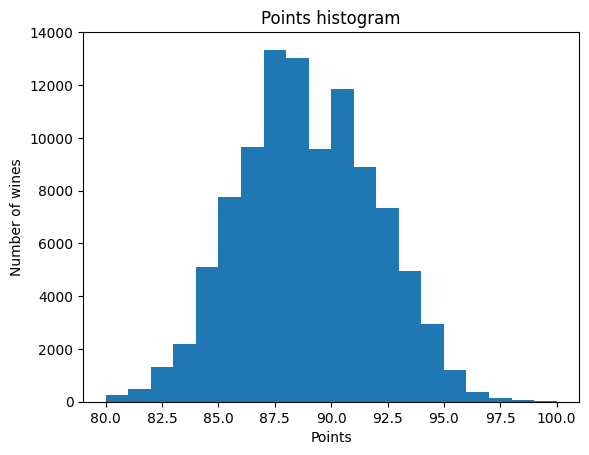

In [4]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("Number of wines")
plt.xlabel("Points")
plt.show()

# **Prepare Labels**

In [5]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

# **Split Data**

In [6]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


# **Check length of Split Datas**

In [7]:
len(train), len(val), len(test)

(80399, 10050, 10050)

# **Shuffle and convert to tensorflow dataset**

In [8]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [9]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

# **Model 1**

# **Embedding + Model (Build Model (Pretrained Embeddings))**

In [10]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [11]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.4506048 , -0.13053565, -0.14067416, ..., -0.12201788,
        -0.16575186, -0.10144649],
       [ 0.4477694 , -0.0836738 ,  0.02705365, ...,  0.06551269,
        -0.21877557,  0.07439608],
       [ 0.4639293 , -0.19799843, -0.21075934, ..., -0.23397009,
        -0.18744269,  0.09216765],
       ...,
       [ 0.38990402,  0.00324867,  0.1044355 , ...,  0.00762418,
        -0.0327909 , -0.01062019],
       [ 0.32816312, -0.31332734, -0.02039889, ..., -0.00781091,
        -0.18022351, -0.23590533],
       [ 0.7652485 , -0.33604035,  0.19424275, ...,  0.15000042,
        -0.31479433, -0.01154651]], dtype=float32)>

In [12]:
class HubEmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self, hub_url, trainable=True, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(
            hub_url,
            trainable=trainable,
            dtype=tf.string
        )

    def call(self, inputs):
        return self.hub_layer(inputs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 50)  # nnlm-en-dim50 outputs 50-dim vectors


In [13]:
input_layer = tf.keras.Input(shape=(), dtype=tf.string)

x = HubEmbeddingLayer("https://tfhub.dev/google/nnlm-en-dim50/2")(input_layer)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)



# **Compile & train the model**

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# **Evaluate the model (calculate the accuracy and loss)**

In [15]:
model.evaluate(train_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6117 - loss: 0.6782


[0.6782429218292236, 0.6095473766326904]

In [16]:
model.evaluate(valid_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6145 - loss: 0.6762


[0.6775479316711426, 0.6087562441825867]

In [17]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5988 - loss: 0.6760 - val_accuracy: 0.6249 - val_loss: 0.6508
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6272 - loss: 0.6548 - val_accuracy: 0.6363 - val_loss: 0.6309
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6378 - loss: 0.6391 - val_accuracy: 0.6663 - val_loss: 0.6117
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6470 - loss: 0.6246 - val_accuracy: 0.6863 - val_loss: 0.5983
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.6572 - loss: 0.6145 - val_accuracy: 0.6922 - val_loss: 0.5902


# **Plot the accuracy and loss (visualization)**

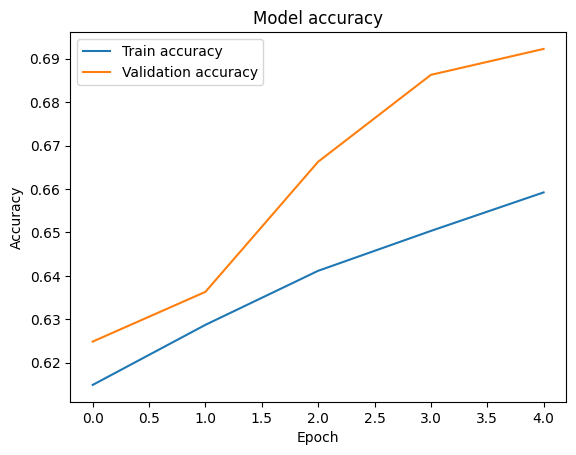

In [18]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()


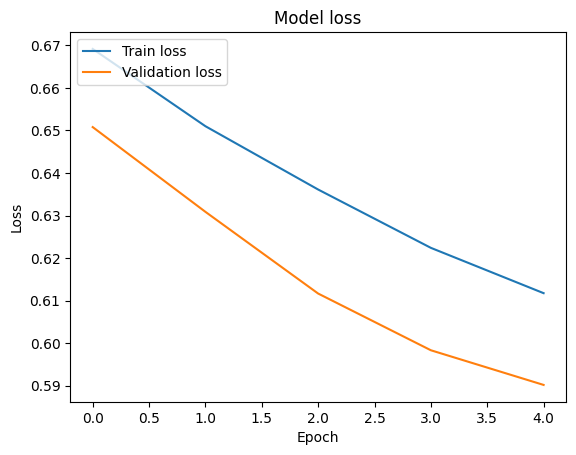

In [19]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')

plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()


In [20]:
model.evaluate(test_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6818 - loss: 0.5888


[0.5904517769813538, 0.6839801073074341]

In [21]:
# Sample reviews (raw text)
sample_reviews = [
    "A beautifully balanced wine with rich blackberry flavors, silky tannins, and a long elegant finish.",
    "Simple and light-bodied with muted fruit flavors. Lacks complexity and finishes quickly."
]

# Convert the list of reviews to a TensorFlow tensor of strings
input_tensor = tf.convert_to_tensor(sample_reviews, dtype=tf.string)

# Predict wine quality (probability for 90+ points)
predictions = model.predict(input_tensor)

# Print the predictions
for review, pred in zip(sample_reviews, predictions):
    print("Review:", review)
    print("Predicted probability of 90+ points:", float(pred))
    print("Predicted label:", int(pred >= 0.5))  # Convert to binary label: 1 for 90+ points, 0 for <90 points
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Review: A beautifully balanced wine with rich blackberry flavors, silky tannins, and a long elegant finish.
Predicted probability of 90+ points: 0.3201485574245453
Predicted label: 0
--------------------------------------------------
Review: Simple and light-bodied with muted fruit flavors. Lacks complexity and finishes quickly.
Predicted probability of 90+ points: 0.27837395668029785
Predicted label: 0
--------------------------------------------------


/tmp/ipython-input-2406854528.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted probability of 90+ points:", float(pred))
/tmp/ipython-input-2406854528.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Predicted label:", int(pred >= 0.5))  # Convert to binary label: 1 for 90+ points, 0 for <90 points


# **Model 2**

# **LSTM (Long Short-Term Memory)**

In [22]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [23]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# **Compile & train the model**

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# **Evaluate the model (calculate the accuracy and loss)**

In [26]:
model.evaluate(train_data)
model.evaluate(valid_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - accuracy: 0.5707 - loss: 0.6927
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.5645 - loss: 0.6928


[0.6927216649055481, 0.5712437629699707]

In [27]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 457ms/step - accuracy: 0.6413 - loss: 0.6367 - val_accuracy: 0.8119 - val_loss: 0.4033
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 425ms/step - accuracy: 0.8253 - loss: 0.3911 - val_accuracy: 0.8295 - val_loss: 0.3670
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 438ms/step - accuracy: 0.8457 - loss: 0.3556 - val_accuracy: 0.8358 - val_loss: 0.3585
Epoch 4/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 426ms/step - accuracy: 0.8500 - loss: 0.3417 - val_accuracy: 0.8339 - val_loss: 0.3571
Epoch 5/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 422ms/step - accuracy: 0.8536 - loss: 0.3390 - val_accuracy: 0.8342 - val_loss: 0.3557


In [28]:
model.evaluate(test_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 0.8376 - loss: 0.3528


[0.3554382026195526, 0.8382089734077454]

# **Input data**

In [29]:
sample_reviews = [
    "A beautifully balanced wine with rich blackberry flavors, silky tannins, and a long elegant finish.",
    "Simple and light-bodied with muted fruit flavors. Lacks complexity and finishes quickly."
]

sample_reviews = tf.constant(sample_reviews)

predictions = model.predict(sample_reviews)

for review, pred in zip(sample_reviews.numpy(), predictions):
    print("Review:", review.decode("utf-8"))
    print("Predicted probability of 90+ points:", float(pred[0]))
    print("Predicted label:", int(pred[0] >= 0.5))
    print("-" * 50)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Review: A beautifully balanced wine with rich blackberry flavors, silky tannins, and a long elegant finish.
Predicted probability of 90+ points: 0.8693037033081055
Predicted label: 1
--------------------------------------------------
Review: Simple and light-bodied with muted fruit flavors. Lacks complexity and finishes quickly.
Predicted probability of 90+ points: 0.0009176193852908909
Predicted label: 0
--------------------------------------------------
